### 🔁 What is Iterative Retrieval in Agentic RAG?
Combined both Iterative And Self reflection

✅ Definition:
Iterative Retrieval is a dynamic strategy where an AI agent doesn't settle for the first batch of retrieved documents. Instead, it evaluates the adequacy of the initial context, and if necessary, it:

- Refines the query,
- Retrieves again,
- Repeats the process until it’s confident enough to answer the original question.

🧠 Why Use It?
In standard RAG:

- A single retrieval step is done, and the LLM uses it to answer.
- If the documents were incomplete or irrelevant, the answer may fail.

In Iterative RAG:

- The agent reflects on the retrieved content and the answer it produced.
- If it’s unsure, it can refine its search (like a human researcher would).

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END

c:\Users\palas\Desktop\GenAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

In [4]:
### Load And Embed Documents
docs = TextLoader("research_notes.txt", encoding="utf-8").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [5]:
### Define Agent State

class IterativeRAGState(BaseModel):
    question: str
    refined_question: str = ""
    retrieved_docs: List[Document] = []
    answer: str = ""
    verified: bool = False
    attempts: int = 0


In [6]:
### Retrieve Node
def retrieve_docs(state: IterativeRAGState) -> IterativeRAGState:
    query = state.refined_question or state.question
    docs = retriever.invoke(query)
    return state.model_copy(update={"retrieved_docs": docs})


In [7]:
### Reflect And Verify
def generate_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    context = "\n\n".join(doc.page_content for doc in state.retrieved_docs)
    prompt = f"""Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    response = llm.invoke(prompt.strip()).content.strip()
    return state.model_copy(update={"answer": response, "attempts": state.attempts + 1})

In [8]:
## Reflect on answer
def reflect_on_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
Evaluate whether the answer below is factually sufficient and complete.

Question: {state.question}
Answer: {state.answer}

Respond 'YES' if it's complete, otherwise 'NO' with feedback.
"""
    feedback = llm.invoke(prompt).content.lower()
    verified = "yes" in feedback
    return state.model_copy(update={"verified": verified})


In [9]:
## Refine query
def refine_query(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
The answer appears incomplete. Suggest a better version of the query that would help retrieve more relevant context.

Original Question: {state.question}
Current Answer: {state.answer}
"""
    new_query = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"refined_question": new_query})


In [14]:
builder = StateGraph(IterativeRAGState)

builder.add_node("retrieve", retrieve_docs)
builder.add_node("answer", generate_answer)
builder.add_node("reflect", reflect_on_answer)
builder.add_node("refine", refine_query)

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "answer")
builder.add_edge("answer", "reflect")

builder.add_conditional_edges(
    "reflect",
    lambda s: END if s.verified or s.attempts >= 2 else "refine"
)

builder.add_edge("refine", "retrieve")
builder.add_edge("answer", END)

graph = builder.compile()


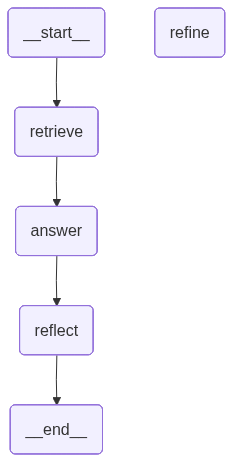

In [16]:
graph

In [13]:
query = "agent loops  and transformer-based systems?"

initial_state = IterativeRAGState(question=query)
final = graph.invoke(initial_state)

print("✅ Final Answer:\n", final["answer"])
print("\n🧠 Verified:", final["verified"])
print("🔁 Attempts:", final["attempts"])


✅ Final Answer:
 Agent loops and transformer-based systems often refer to the structure and workflow of machine learning models, especially in natural language processing and conversation AI tasks. Here's how they can relate to each other based on the context provided:

1. **Agent Loops**: In conversational AI, an agent loop usually refers to the cycle of taking user input, processing it with a model or a series of models, and then generating a response back to the user. This involves maintaining a context of the conversation to ensure coherent and contextually relevant interactions.

2. **Transformer-Based Systems**: Transformers are a type of model architecture particularly effective for tasks that require understanding context over sequences, such as languages. They are characterized by attention mechanisms, which enable them to focus selectively on parts of the input sequence.

In the context you provided, agent loops in transformer-based systems might involve:

- **Multi-Turn Chat

In [14]:
final

{'question': 'agent loops  and transformer-based systems?',
 'refined_question': 'To find relevant information about "agent loops" in relation to transformer-based systems, you might consider refining the query to capture both the iterative processes and integration aspects. Here\'s a suggested version of the query:\n\n"How are agent loops implemented and leveraged in transformer-based AI systems, particularly focusing on feedback mechanisms for continuous learning and system optimization?"\n\nThis refined query aims to gather insights specifically on how cyclic processes or feedback loops (agent loops) are integrated with transformers to enable ongoing improvements and adaptation, exploring topics like model training cycles, deployment strategies, and real-time system adjustments.',
 'retrieved_docs': [Document(id='0eda7bc8-18cd-44de-a68d-66534044f0c1', metadata={'source': 'internal_docs.txt'}, page_content='Optimizations:\n\n- Distillation of teacher-student models using response ali

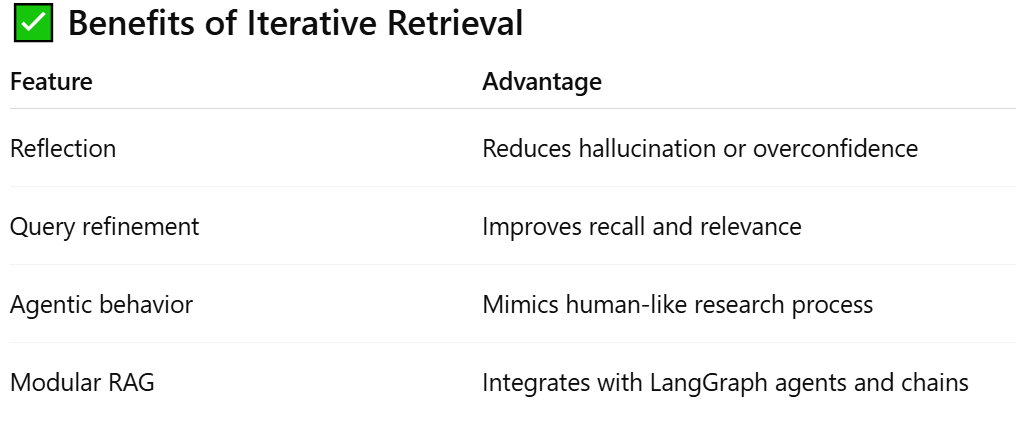